## Cycling Infrastructure Data

Looking deep into the cycling infrastructure

In [1]:
# import libraries

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Cycle lanes

In [2]:
cycle_lane = gpd.read_file('data/cycle_lane_track.json').to_crs('EPSG:27700')

In [3]:
cycle_lane['road_length'] = cycle_lane.length

In [4]:
cycle_lane.dtypes

FEATURE_ID       object
SVDATE           object
CLT_CARR         object
CLT_SEGREG       object
CLT_STEPP        object
CLT_PARSEG       object
CLT_SHARED       object
CLT_MANDAT       object
CLT_ADVIS        object
CLT_PRIORI       object
CLT_CONTRA       object
CLT_BIDIRE       object
CLT_CBYPAS       object
CLT_BBYPAS       object
CLT_PARKR        object
CLT_WATERR       object
CLT_PTIME        object
CLT_ACCESS       object
CLT_COLOUR       object
BOROUGH          object
PHOTO1_URL       object
PHOTO2_URL       object
geometry       geometry
road_length     float64
dtype: object

Index(['FEATURE_ID', 'SVDATE', 'CLT_CARR', 'CLT_SEGREG', 'CLT_STEPP',
       'CLT_PARSEG', 'CLT_SHARED', 'CLT_MANDAT', 'CLT_ADVIS', 'CLT_PRIORI',
       'CLT_CONTRA', 'CLT_BIDIRE', 'CLT_CBYPAS', 'CLT_BBYPAS', 'CLT_PARKR',
       'CLT_WATERR', 'CLT_PTIME', 'CLT_ACCESS', 'CLT_COLOUR', 'BOROUGH',
       'PHOTO1_URL', 'PHOTO2_URL', 'geometry', 'road_length'],
      dtype='object')

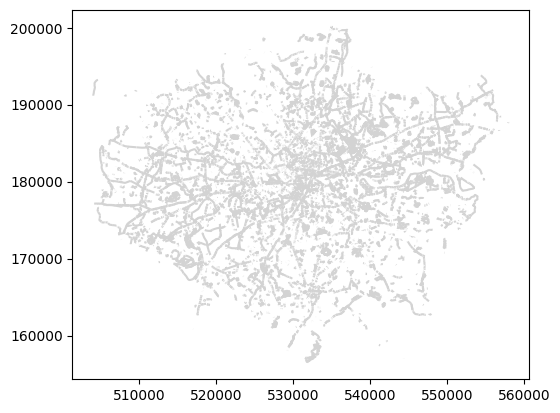

In [120]:
cycle_lane.plot(
    color = 'lightgray'
)

cycle_lane.columns

#### Summary Statistics

Calculate the summary statistics for cycle lane

In [6]:
# summary statistics

cycle_lane.length


0         134.240613
1          85.310122
2         251.131588
3         142.592121
4          24.695457
            ...     
24971     562.460493
24972      45.089943
24973    6558.899125
24974      38.864592
24975     254.639478
Length: 24976, dtype: float64

### Points Data

The data we have from the TfL cycling infrastructure

- `cycle_parking.json`
- `restricted_point.json`
- `signage.json`
- `signal.json`
- `traffic_calming.json`



In [7]:
# load points data
cycle_parking = gpd.read_file('data/cycling_infrastructure/cycle_parking.json').to_crs('EPSG:27700')
restricted_point = gpd.read_file('data/cycling_infrastructure/restricted_point.json').to_crs('EPSG:27700')
signage = gpd.read_file('data/cycling_infrastructure/signage.json').to_crs('EPSG:27700')
signal = gpd.read_file('data/cycling_infrastructure/signal.json').to_crs('EPSG:27700')
traffic_calming = gpd.read_file('data/cycling_infrastructure/traffic_calming.json').to_crs('EPSG:27700')

### Road network

Roads from OS open roads

In [121]:
roads = gpd.read_file('data/london_roads.gpkg')

## Cycling Traffic

The cycling traffic, measured in 2 different ways: active travel counts and DfT traffic data.



### Active travel count

Not using this for analysis!!!

In [23]:
# load data

atc_path = os.path.join('data', 'active_travel_counts')
fn = ['2022 W1 spring-Central.csv', '2022 W1 spring-Inner-Part1.csv', '2022 W1 spring-Inner-Part2.csv', '2022 W1 spring-Outer.csv', '2022 W1 spring-Cycleways.csv']

traffic_df = []
for f in fn:
    traffic_df.append(
        pd.read_csv(os.path.join(atc_path,f))
    )

traffic_concat = pd.concat(traffic_df)


In [24]:
# drop NA values
traffic_concat.Path.dropna(inplace = True)

In [25]:
traffic_concat.Mode.unique()

array(['Cargo bikes', 'Conventional cycles', 'E-scooters', 'Pedestrians',
       'Cycle hire bikes', 'Private cycles', 'Cycles', 'Male cyclists',
       'Female cyclists', 'Unknown cyclists'], dtype=object)

In [26]:
traffic_by_points = pd.DataFrame(traffic_concat[traffic_concat['Mode'] != 'Pedestrians'].groupby(['UnqID', 'Mode']).agg(
    {
        'Count': 'mean'
    }
).reset_index().groupby('UnqID')['Count'].sum()).rename(columns = {'Count': 'cycle_counts'})

In [27]:
traffic_by_points

,cycle_counts
UnqID,
ML0001,14.139062
ML0002,11.954688
ML0003,6.606250
ML0004,4.781250
ML0005,21.690104
...,...
ML2051,16.994792
ML2052,27.078125
ML2055,82.380208


In [71]:
# load locations
locations = pd.read_csv(os.path.join(atc_path, '1 Monitoring locations.csv'))
locations_gdf = gpd.GeoDataFrame(
    locations,
    geometry = gpd.points_from_xy(locations['Easting (UK Grid)'], locations['Northing (UK Grid)'], crs = 'EPSG:27700')
)

In [72]:
# get traffic by location
locations_gdf = locations_gdf.merge(
    traffic_by_points, left_on = 'Site ID', right_index = True
)

### DfT traffic data



In [37]:
london_traffic = pd.read_csv('data/london_traffic_boroughs.csv')

london_traffic

,Unnamed: 0,Local_authority_id,name,ONS_code,year,link_length_km,link_length_miles,cars_and_taxis,all_motor_vehicles
0,56,57,Barnet,E09000003,1993,729.225,453.12,8.194056e+08,9.619031e+08
1,64,66,Hillingdon,E09000017,1993,719.211,446.90,1.089714e+09,1.274280e+09
2,90,93,Tower Hamlets,E09000030,1993,282.780,175.71,4.404428e+08,5.559174e+08
3,93,96,Islington,E09000019,1993,240.063,149.17,2.390268e+08,3.011351e+08
4,100,103,Southwark,E09000028,1993,388.328,241.30,4.257460e+08,5.284653e+08
...,...,...,...,...,...,...,...,...,...
985,6114,177,Sutton,E09000029,2022,468.830,291.32,3.605919e+08,4.560344e+08
986,6115,178,Kingston upon Thames,E09000021,2022,342.960,213.11,4.683174e+08,5.890935e+08
987,6121,185,Harrow,E09000015,2022,472.260,293.45,3.172663e+08,3.890621e+08
988,6136,201,Havering,E09000016,2022,684.150,425.11,7.893772e+08,1.104040e+09


In [44]:
london_traffic_pivot = london_traffic.pivot_table(
    values = 'all_motor_vehicles',
    columns = 'year',
    index = 'ONS_code'
).add_prefix('DfT_')

london_traffic_pivot

year,DfT_1993,DfT_1994,DfT_1995,DfT_1996,DfT_1997,DfT_1998,DfT_1999,DfT_2000,DfT_2001,DfT_2002,...,DfT_2013,DfT_2014,DfT_2015,DfT_2016,DfT_2017,DfT_2018,DfT_2019,DfT_2020,DfT_2021,DfT_2022
ONS_code,,,,,,,,,,,,,,,,,,,,,
E09000001,1.240260e+08,1.263218e+08,1.265158e+08,1.298277e+08,1.324982e+08,1.347189e+08,1.344134e+08,1.315497e+08,1.268615e+08,1.216209e+08,...,9.862477e+07,1.013440e+08,1.013555e+08,9.924262e+07,9.583624e+07,9.263199e+07,9.329609e+07,7.266374e+07,7.956927e+07,7.488486e+07
E09000002,3.430461e+08,3.470355e+08,3.430952e+08,3.420780e+08,3.400271e+08,3.382416e+08,3.569110e+08,3.526342e+08,3.545453e+08,3.573560e+08,...,3.929164e+08,4.056668e+08,4.055949e+08,4.184031e+08,4.115314e+08,4.103061e+08,4.105054e+08,3.473927e+08,3.746127e+08,3.983885e+08
E09000003,9.619031e+08,9.806793e+08,9.797544e+08,9.980109e+08,1.014471e+09,1.013052e+09,1.036498e+09,1.021734e+09,1.034810e+09,1.038349e+09,...,1.090261e+09,1.102872e+09,1.097543e+09,1.088220e+09,1.116228e+09,1.114928e+09,1.132048e+09,8.996059e+08,1.005288e+09,1.023084e+09
E09000004,5.404198e+08,5.482486e+08,5.445228e+08,5.612441e+08,5.679980e+08,5.728568e+08,5.813771e+08,6.045888e+08,6.200133e+08,6.190958e+08,...,6.006944e+08,6.167879e+08,6.216875e+08,6.407191e+08,6.420157e+08,6.306800e+08,6.422622e+08,5.399976e+08,5.992312e+08,6.162734e+08
E09000005,5.647034e+08,5.721023e+08,5.673605e+08,5.820185e+08,5.797274e+08,5.945766e+08,6.083238e+08,6.158157e+08,6.137388e+08,6.327108e+08,...,5.913313e+08,6.109148e+08,5.978076e+08,6.261373e+08,6.196218e+08,6.207019e+08,6.365780e+08,5.488709e+08,5.997755e+08,5.978327e+08
E09000006,7.853778e+08,7.860926e+08,7.849865e+08,7.981329e+08,8.055403e+08,8.153160e+08,8.237797e+08,8.347979e+08,8.588904e+08,8.648366e+08,...,8.608329e+08,8.797766e+08,8.861329e+08,9.069841e+08,9.012401e+08,8.813946e+08,9.124605e+08,7.425883e+08,8.498127e+08,8.701679e+08
E09000007,3.845647e+08,3.874729e+08,3.897701e+08,3.869137e+08,3.884078e+08,3.899754e+08,3.944047e+08,3.805384e+08,3.763873e+08,3.706007e+08,...,3.089884e+08,3.132673e+08,3.127622e+08,3.158096e+08,3.126006e+08,3.036875e+08,3.002133e+08,2.436641e+08,2.705145e+08,2.765077e+08
E09000008,8.206364e+08,8.317327e+08,8.268468e+08,8.317642e+08,8.337942e+08,8.408028e+08,8.554180e+08,8.502677e+08,8.629479e+08,8.689894e+08,...,8.169563e+08,8.283882e+08,8.268003e+08,8.490742e+08,8.383382e+08,8.282874e+08,8.434897e+08,7.057423e+08,7.987716e+08,8.194500e+08
E09000009,7.858113e+08,7.947082e+08,7.855077e+08,7.991749e+08,7.983197e+08,8.002107e+08,8.583148e+08,8.651404e+08,8.699295e+08,8.752391e+08,...,8.434334e+08,8.261381e+08,8.310922e+08,8.353186e+08,8.502779e+08,8.471215e+08,8.510597e+08,7.218582e+08,7.807462e+08,8.033812e+08


In [38]:
raw_data = pd.read_csv('data/dft_traffic_counts_raw_counts.csv')

In [39]:
raw_data.head(5)

,Count_point_id,Direction_of_travel,Year,Count_date,hour,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,...,Buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles
0,749,E,2014,2014-06-25 00:00:00,7,3,Scotland,S92000003,39,East Ayrshire,...,5.0,31,15.0,4.0,4.0,4.0,13,12.0,52.0,935.0
1,749,E,2014,2014-06-25 00:00:00,8,3,Scotland,S92000003,39,East Ayrshire,...,7.0,103,29.0,3.0,2.0,7.0,18,20.0,79.0,1102.0
2,749,E,2014,2014-06-25 00:00:00,9,3,Scotland,S92000003,39,East Ayrshire,...,14.0,88,21.0,3.0,5.0,9.0,17,19.0,74.0,773.0
3,749,E,2014,2014-06-25 00:00:00,10,3,Scotland,S92000003,39,East Ayrshire,...,8.0,90,31.0,6.0,10.0,7.0,18,17.0,89.0,778.0
4,749,E,2014,2014-06-25 00:00:00,11,3,Scotland,S92000003,39,East Ayrshire,...,18.0,75,38.0,2.0,2.0,3.0,16,24.0,85.0,875.0


## Summarise by Statistical Area

Summarise length of infrastructure, number of casualties and traffic by MSOA / borough

In [40]:
# load lsoa data

lsoa = gpd.read_file('data/boundary/LSOA_2011_London_gen_MHW.shp').to_crs('EPSG:27700')
msoa = gpd.read_file('data/boundary/MSOA_2011_London_gen_MHW.shp').to_crs('EPSG:27700')
boroughs = gpd.read_file('data/boundary/London_Borough_Excluding_MHW.shp').to_crs('EPSG:27700')

In [9]:
# get length for cycle lane
cycle_lane['road_length'] = cycle_lane.length

### Summarise by MSOA

In [10]:
# cycle data
joined_data = msoa.sjoin(cycle_lane, predicate = 'intersects')
msoa_cycle_routes = pd.DataFrame(joined_data.groupby('MSOA11CD').road_length.sum())
msoa_cycle = msoa.merge(msoa_cycle_routes, left_on = 'MSOA11CD', right_index = True, how = 'left')

In [14]:
# get cycle casualties
casualties = gpd.read_file('data/2022_casualties.gpkg')
cycle_casualties = casualties[casualties['Casualty Mode of Travel'] == 'Pedal Cycle']

In [15]:
# create dataframe
msoa_casualties = msoa.sjoin(cycle_casualties, predicate = 'contains')
# join with msoa table
msoa_cycle = msoa_cycle.merge(msoa_casualties.groupby('MSOA11CD')['_Casualty Count'].sum(), left_on = 'MSOA11CD', right_index = True)

In [17]:
# normalise
msoa_cycle['cycle_density'] = msoa_cycle['road_length'] / msoa_cycle.area
msoa_cycle['casualty_density'] = msoa_cycle['_Casualty Count'] / msoa_cycle.area

#### Cycle Infrastructure Density

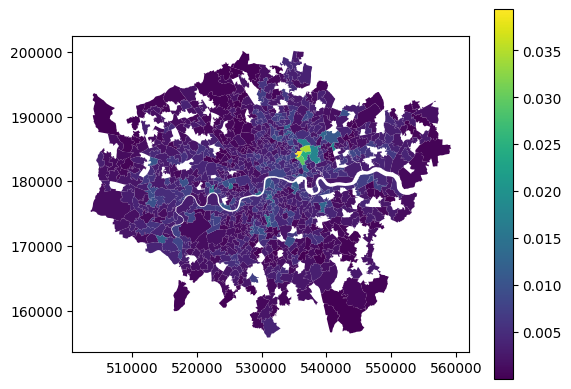

In [18]:
msoa_cycle.plot(
    column = 'cycle_density',
    legend = True
)

plt.show()

#### Casualty Density

<Axes: >

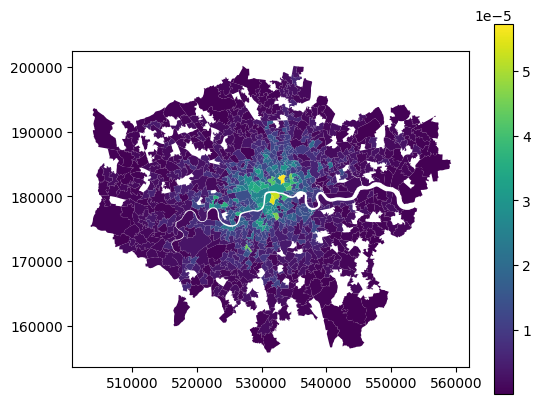

In [19]:
msoa_cycle.plot(
    column = 'casualty_density',
    legend = True
)

#### Active travel counts

In [29]:
traffic_counts = pd.DataFrame(msoa.sjoin(
    locations_gdf.merge(traffic_by_points, left_on = 'Site ID', right_index = True),
    predicate = 'intersects'
).groupby('MSOA11CD').cycle_counts.mean())

In [30]:
msoa_cycle = msoa_cycle.merge(traffic_counts, left_on = 'MSOA11CD', right_index = True)

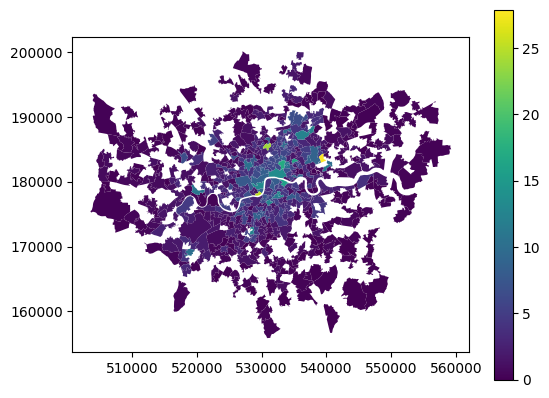

In [31]:
# plot count of cycle
msoa_cycle.plot(
    column = 'cycle_counts',
    legend = True
)

plt.show()

In [32]:
msoa_non0 = msoa_cycle[msoa_cycle['cycle_counts'] != 0].copy()

msoa_non0['casualty_per_cycle'] = msoa_non0['casualty_density'] * 1000000 / msoa_non0['cycle_counts']

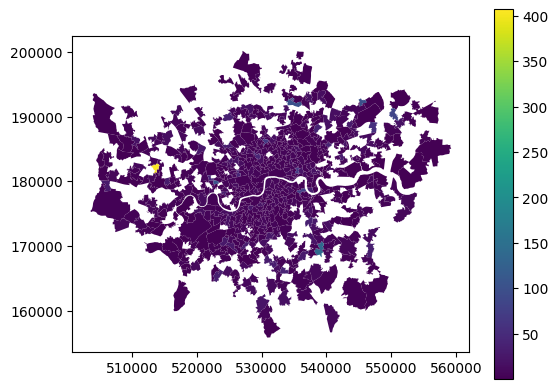

In [35]:
# plot count of cycle
msoa_non0.plot(
    column = 'casualty_per_cycle',
    legend = True
)

plt.show()

In [36]:
msoa_non0.to_file('data/msoa_cycling_data.gpkg', driver = 'GPKG')

#### Regression

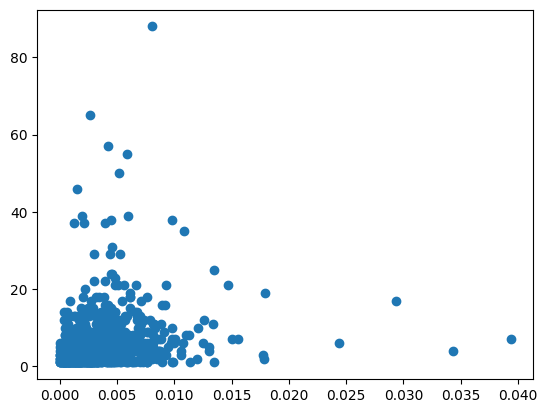

In [20]:
plt.scatter(
    x = msoa_cycle['cycle_density'],
    y = msoa_cycle['_Casualty Count']
)

In [21]:
msoa_cycle_dropna = msoa_cycle.dropna()

# run linear regression
model = sm.OLS(msoa_cycle_dropna['casualty_density'], sm.add_constant(msoa_cycle_dropna['cycle_density']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       casualty_density   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     46.58
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           1.68e-11
Time:                        09:19:30   Log-Likelihood:                 8645.3
No. Observations:                 842   AIC:                        -1.729e+04
Df Residuals:                     840   BIC:                        -1.728e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.841e-06   4.19e-07     11.543      0.000    4.02e-06    5.66e-06
cycle_density     0.0006   8.56e-05      6.825      0.000       0.000       0.001
==============================================================================
Omnibus:                      392.470   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1914.455
Skew:                           2.156   Prob(JB):                         0.00
Kurtosis:                       8.998   Cond. No.                         295.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

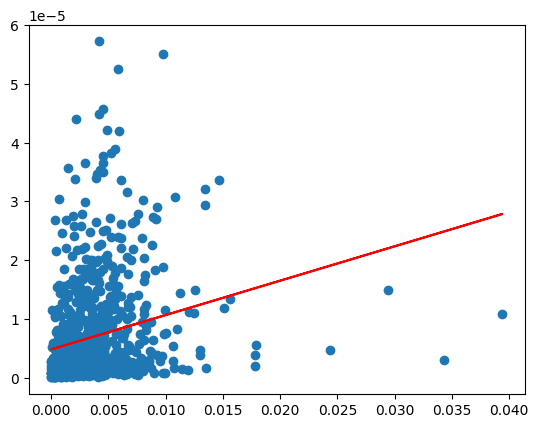

In [22]:
plt.scatter(
    x = msoa_cycle['cycle_density'],
    y = msoa_cycle['casualty_density']
)

plt.plot(
    msoa_cycle_dropna['cycle_density'], results.predict(sm.add_constant(msoa_cycle_dropna['cycle_density'])),
    color = 'red'
)

### Summarise by borough

In [46]:
boroughs

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."
5,Havering,E09000016,11445.735,210.763,F,None,None,"POLYGON ((549893.900 181459.800, 549894.600 18..."
6,Hillingdon,E09000017,11570.063,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510615.200 19..."
7,Harrow,E09000015,5046.330,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510660.000 19..."
8,Brent,E09000005,4323.270,0.000,F,None,None,"POLYGON ((525201.000 182512.600, 525181.500 18..."
9,Barnet,E09000003,8674.837,0.000,F,None,None,"POLYGON ((524579.900 198355.200, 524594.300 19..."


In [123]:
# roads summarise by borough
boroughs_roads = pd.DataFrame(
    boroughs.sjoin(
        roads,
        predicate = 'intersects'
    ).groupby('GSS_CODE')['length'].sum()
)

In [125]:
boroughs_roads = boroughs_roads.rename(columns = {'length': 'road_network_length'})

In [78]:
# cycle active travel summarise by borough
boroughs_atc = pd.DataFrame(
    boroughs.sjoin(
        locations_gdf,
        predicate = 'intersects'
    ).groupby('GSS_CODE').cycle_counts.mean()
).rename(columns = {'cycle_counts': 'cycle_traffic_atc'})

In [140]:
# cycle lane data
boroughs_cycle_routes = pd.DataFrame(boroughs.sjoin(cycle_lane, predicate = 'intersects').groupby('GSS_CODE').road_length.sum()).rename(columns = {'road_length': 'cycle_network_length'})

# cycle casualties_data
boroughs_cycle_casualties = pd.DataFrame(boroughs.sjoin(cycle_casualties, predicate = 'contains').groupby('GSS_CODE')['_Casualty Count'].sum()).rename(columns = {'_Casualty Count': 'cycle_casualties'})

# casualties_data
boroughs_casualties = pd.DataFrame(boroughs.sjoin(casualties, predicate = 'contains').groupby('GSS_CODE')['_Casualty Count'].sum()).rename(columns = {'_Casualty Count': 'all_casualties'})


# merge with original data frame
boroughs_cycle_data = boroughs.merge(
    boroughs_casualties, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_cycle_casualties, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_cycle_routes, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_roads, left_on = 'GSS_CODE', right_index = True
).merge(
    london_traffic_pivot, left_on = 'GSS_CODE', right_index = True
).merge(
    boroughs_atc, left_on = 'GSS_CODE', right_index = True
)

In [141]:
boroughs_cycle_data.columns

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry', 'all_casualties', 'cycle_casualties',
       'cycle_network_length', 'road_network_length', 'DfT_1993', 'DfT_1994',
       'DfT_1995', 'DfT_1996', 'DfT_1997', 'DfT_1998', 'DfT_1999', 'DfT_2000',
       'DfT_2001', 'DfT_2002', 'DfT_2003', 'DfT_2004', 'DfT_2005', 'DfT_2006',
       'DfT_2007', 'DfT_2008', 'DfT_2009', 'DfT_2010', 'DfT_2011', 'DfT_2012',
       'DfT_2013', 'DfT_2014', 'DfT_2015', 'DfT_2016', 'DfT_2017', 'DfT_2018',
       'DfT_2019', 'DfT_2020', 'DfT_2021', 'DfT_2022', 'cycle_traffic_atc'],
      dtype='object')

In [190]:
# normalise by area
boroughs_cycle_data['cycle_casualties_per_area'] = boroughs_cycle_data['cycle_casualties'] / boroughs_cycle_data.area
boroughs_cycle_data['all_casualties_per_area'] = boroughs_cycle_data['all_casualties'] / boroughs_cycle_data.area
boroughs_cycle_data['cycle_lane_per_area'] = boroughs_cycle_data['cycle_network_length'] / boroughs_cycle_data.area

# cycle network ratio to the road ratio
boroughs_cycle_data['cycle_network_ratio'] = boroughs_cycle_data['cycle_network_length'] / boroughs_cycle_data['road_network_length']

# normalise by traffic

# DfT data is vehicle / mile, so no need to do the normalisation before
# ATC is average density of traffic, so need to normalise by area
boroughs_cycle_data['cycle_casualties_per_traffic'] = boroughs_cycle_data['cycle_casualties'] / boroughs_cycle_data['DfT_2022']
boroughs_cycle_data['cycle_casualties_per_traffic_atc'] = boroughs_cycle_data['cycle_casualties_per_area'] / boroughs_cycle_data['cycle_traffic_atc']

boroughs_cycle_data['all_casualties_per_traffic'] = boroughs_cycle_data['all_casualties'] / boroughs_cycle_data['DfT_2022']
boroughs_cycle_data['all_casualties_per_traffic_atc'] = boroughs_cycle_data['all_casualties_per_area'] / boroughs_cycle_data['cycle_traffic_atc']



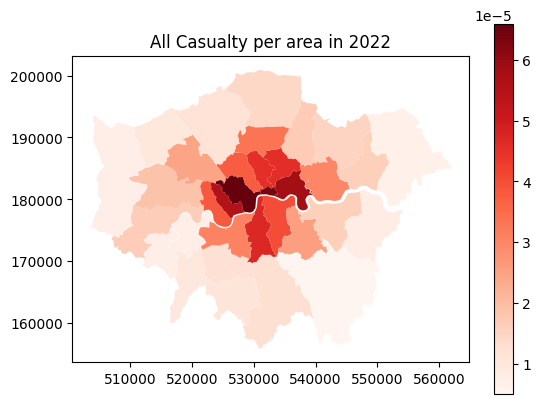

In [191]:
# plot casualties per area
boroughs_cycle_data.plot(
    column = 'all_casualties_per_area',
    legend = True,
    cmap = 'Reds'
)

plt.title('All Casualty per area in 2022')

plt.show()

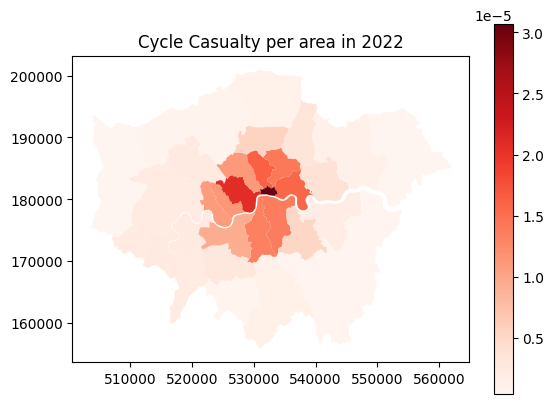

In [182]:
# plot casualties per area
boroughs_cycle_data.plot(
    column = 'cycle_casualties_per_area',
    legend = True,
    cmap = 'Reds'
)

plt.title('Cycle Casualty per area in 2022')

plt.show()

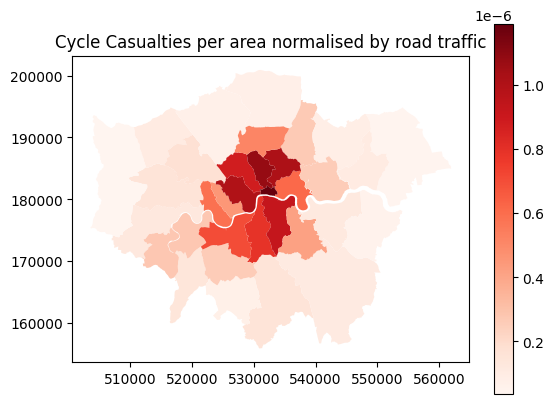

In [170]:
# plot casualties per traffic
boroughs_cycle_data.plot(
    column = 'casualties_per_traffic',
    legend = True,
    cmap = 'Reds'
)

plt.title('Cycle Casualties per area normalised by road traffic')

plt.show()

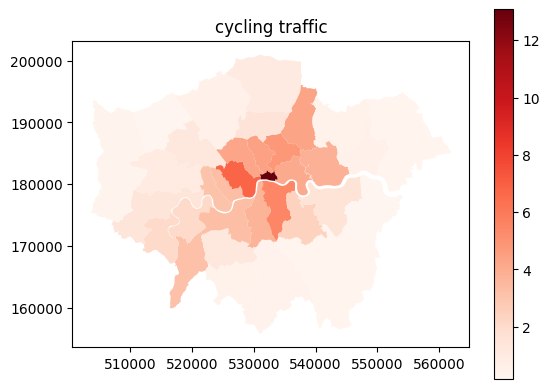

In [145]:
# plot cycling traffic
boroughs_cycle_data.plot(
    column = 'cycle_traffic_atc',
    legend = True,
    cmap = 'Reds'
)

plt.title('cycling traffic')

plt.show()

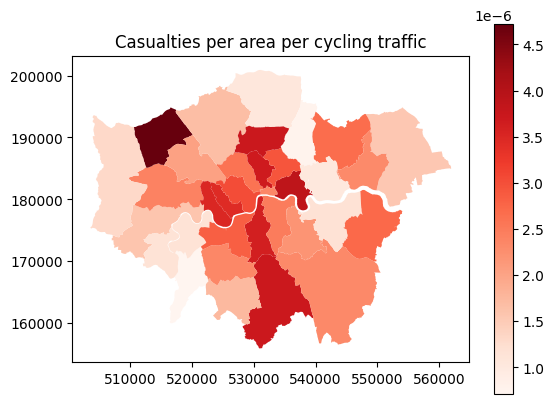

In [146]:
# plot casualties per traffic
boroughs_cycle_data.plot(
    column = 'casualties_per_traffic_atc',
    legend = True,
    cmap = 'Reds'
)

plt.title('Casualties per area per cycling traffic')

plt.show()

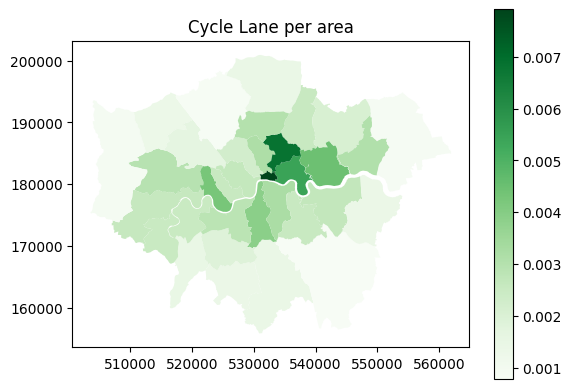

In [167]:
# plot casualties per traffic
boroughs_cycle_data.plot(
    column = 'cycle_lane_per_area',
    legend = True,
    cmap = 'Greens'
)

plt.title('Cycle Lane per area')

plt.show()

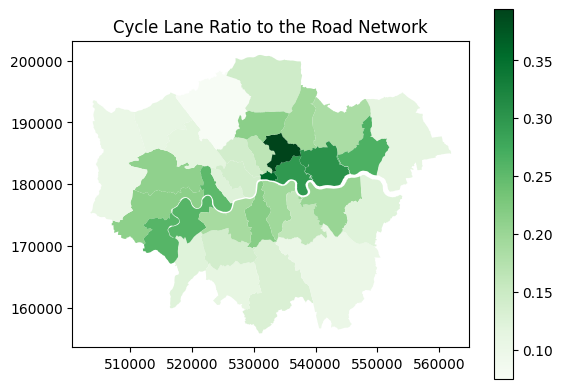

In [169]:
# plot casualties per traffic
boroughs_cycle_data.plot(
    column = 'cycle_network_ratio',
    legend = True,
    cmap = 'Greens'
)

plt.title('Cycle Lane Ratio to the Road Network')

plt.show()

[]

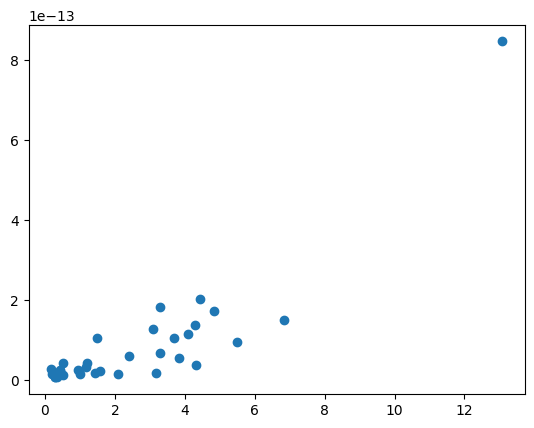

In [189]:
plt.scatter(
    x = boroughs_cycle_data['cycle_traffic_atc'],
    y = boroughs_cycle_data['all_casualties_per_area'] / boroughs_cycle_data['DfT_2022']
)


plt.plot()